# XOR Classification

The XOR classification problem is a classic problem for analyzing the capacity of a model with regard
to capturing the nonlinear decision boundary between two classes.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from mlxtend.plotting import plot_decision_regions

We generate a toy dataset of 200
training examples with two features (x0, x1) drawn from a uniform distribution between [–1, 1).

In [73]:
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1,high=1, size=(200,2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0 # The ground truth labels for the XOR classification problem
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

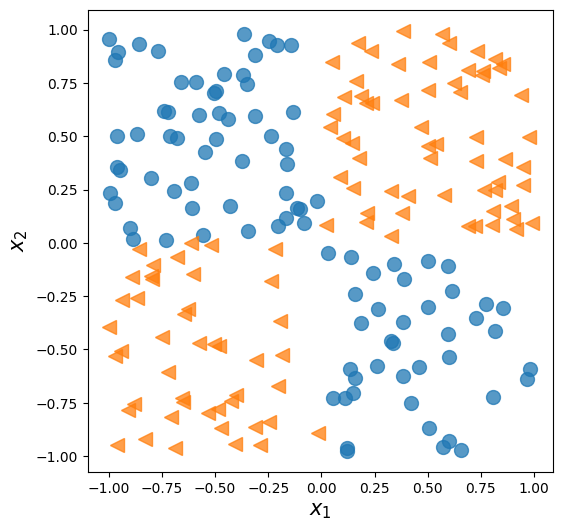

In [74]:
# Scatter plot of XOR data
fig = plt.figure(figsize=(6,6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

We now need to decide what architecture we should choose for this task and dataset. As
a general rule of thumb, the more layers we have, and the more neurons we have in each layer, the
larger the capacity of the model will be. Here, the model capacity can be thought of as a measure of
how readily the model can approximate complex functions. While having more parameters means
the network can fit more complex functions, larger models are usually harder to train (and prone to
overfitting).

### Training

In [75]:
# starting with a simple baseline model
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [76]:
# Initializing the croos-entropy loss function for binary classification and the SGD optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [77]:
# Creating a data loader that uses a batch size of 2 for the training data
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [78]:
# Training the model for 200 epochs and keeping the logs of training
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

### Plotting the learning curves

Text(0.5, 0, 'Epochs ')

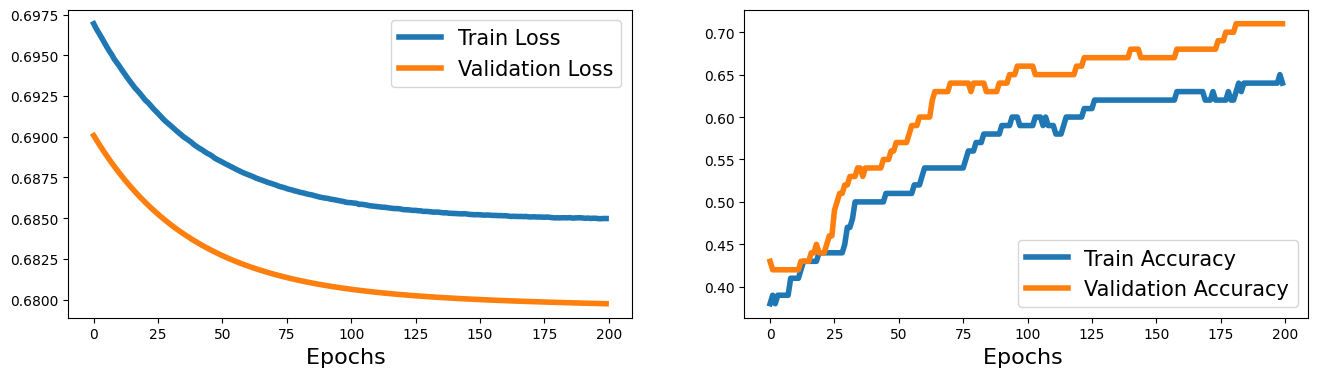

In [79]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train Loss', 'Validation Loss'], fontsize=15)
ax.set_xlabel('Epochs ', fontsize=16)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=15)
ax.set_xlabel('Epochs ', fontsize=16)

As you can see, a simple model with no hidden layer can only derive a linear decision boundary, which
is unable to solve the XOR problem. As a consequence, we can observe that the loss terms for both the
training and the validation datasets are very high, and the classification accuracy is very low.

To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear
activation functions. The universal approximation theorem states that a feedforward NN with a single
hidden layer and a relatively large number of hidden units can approximate arbitrary continuous func-
tions relatively well. Thus, one approach for tackling the XOR problem more satisfactorily is to add a
hidden layer and compare different numbers of hidden units until we observe satisfactory results on
the validation dataset. Adding more hidden units would correspond to increasing the width of a layer.

Alternatively, we can also add more hidden layers, which will make the model deeper. The advantage
of making a network deeper rather than wider is that fewer parameters are required to achieve a
comparable model capacity.

In [80]:
# Adding more hidden layers
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [81]:
# Retraining with additional hidden layers
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs ')

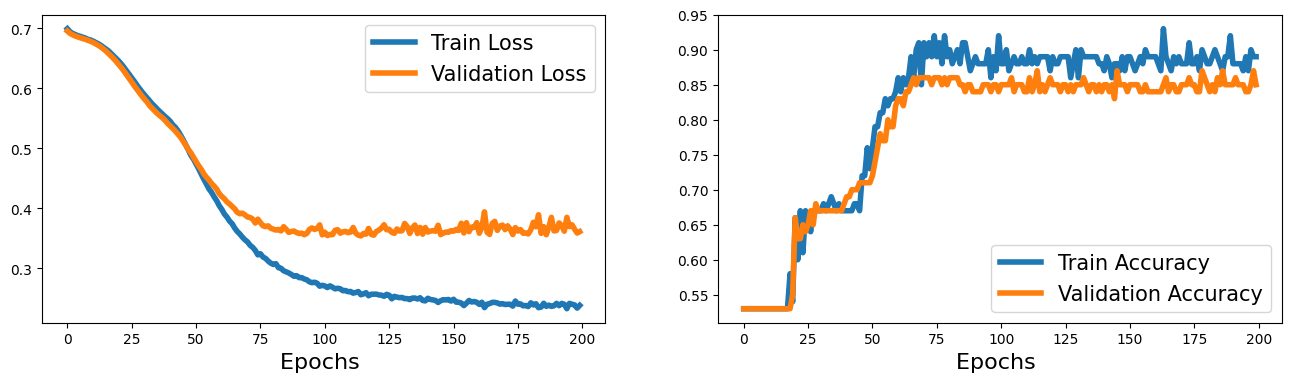

In [82]:
# Plotting the new learning curves
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train Loss', 'Validation Loss'], fontsize=15)
ax.set_xlabel('Epochs ', fontsize=16)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=15)
ax.set_xlabel('Epochs ', fontsize=16)

Now, we can see that the model is able to derive a nonlinear decision boundary for this data, and the
model reaches close to 95 percent accuracy on the training dataset. The validation dataset’s accuracy is 90
percent, which indicates that the model is slightly overfitting.

### Implementing nn.Module class

In [83]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2,4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4,4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4,1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)

        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [84]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [85]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

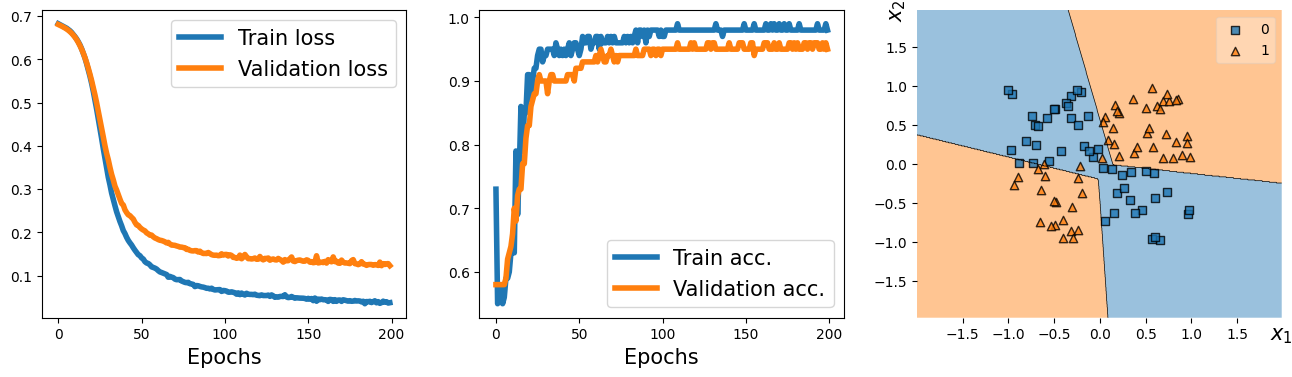

In [86]:
# plotting the training performance with decision region bias
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

### Implementing custom layers 

To illustrate the concept of implementing custom layers, let’s consider a simple example. Imagine we
want to define a new linear layer that computes 𝑤(𝑥 + 𝜖)+ 𝑏 , where 𝜖 refers to a random variable as a
noise variable.

In [87]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)    # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In the constructor, we have added an argument, noise_stddev, to specify the standard deviation for
the distribution of 𝜖 , which is sampled from a Gaussian distribution. Furthermore, notice that in the
forward() method, we have used an additional argument, training=False. We use it to distinguish
whether the layer is used during training or only for prediction (this is sometimes also called inference) or evaluation.

In [88]:
# testing the noisy layer
torch.manual_seed(1)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))


tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


Note that the outputs for the first two calls differ because the NoisyLinear layer
added random noise to the input tensor. The third call outputs [0, 0] as we didn’t
add noise by specifying training=False.

Solving the XOR classification problem with out custom noise layer. We will use the nn.Module class for model building, but this time, we will use our
NoisyLinear layer as the first hidden layer of the multilayer perceptron. 

In [89]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2,4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4,4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4,1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x  = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [90]:
torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [93]:
# training the model again with the same parameters
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()
    
    loss_hist_train[epoch] /= 100/batch_size
    accuracy_hist_train[epoch] /= 100/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred >=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] = is_correct.mean()


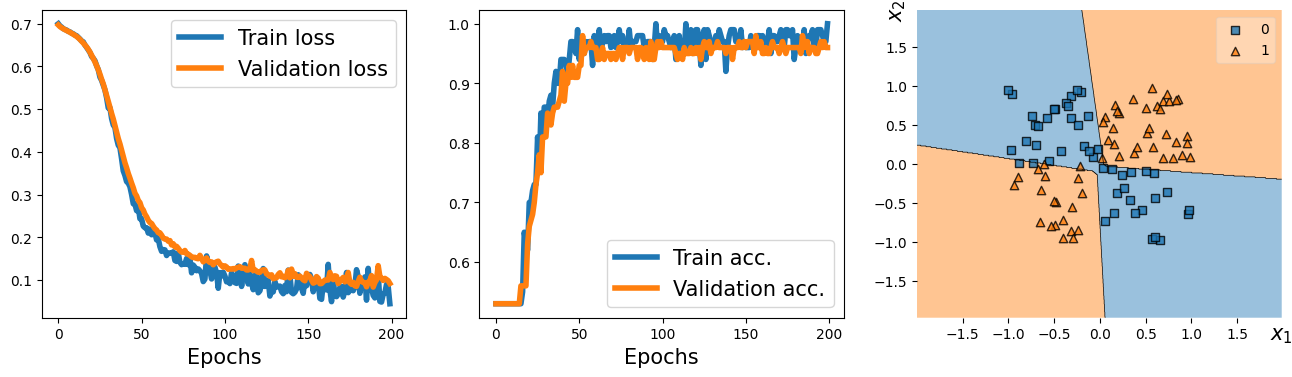

In [95]:
# plotting the training performance with decision region bias
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()